# Calculating time scales for *cis/trans* isomerization


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import os

In [7]:
os.makedirs('autocoorel_data', exist_ok=True)

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [9]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Load in the omega angle trajectories by result

In [10]:
# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)
n_replicas = 6
save_dir = 'omega_data'
all_omega = []

for i in range(n_replicas):
    # load in the individual replica angels     
    angles = np.array(Data.load(f'omega_data/omegas_rep{i}.pkl').array_list)
    all_omega.append(angles)

# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")
all_cistrans[0]

First array shape after conversion: (600030, 3)


array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

#### compile transition probabilities as a function of lag time (in steps)

In [11]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums        
    
    return T

In [12]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

In [13]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [14]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    print('transition_matrices.shape', transition_matrices.shape)
    #print(transition_matrices)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.nanmean([np.log(t2) for t2 in t2_all]))  # Geometric mean
    t2_std = np.exp(np.sqrt(np.nanvar([np.log(t2) for t2 in t2_all])))  # Geometric std dev
    pi_means = np.nanmean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.nanstd(pi_all, axis=0)  # Standard deviation
    
    print('t2_mean, pi_means:', t2_mean, pi_means)
    return pi_means, pi_std, t2_mean, t2_std, transition_matrices

#print(pi_all)

## Let's make an implied timescale plot for each omega angle

In [15]:
## Create a nah filling array where to make sure all the traj are the same length

ntraj = len(all_omega)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

print('traj.shape', traj.shape)
traj


maxlength 600030
traj.shape (6, 600030, 3)


array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]],

       [[1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        ...,
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]],

       [[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.],
        ...,
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 0., 1.]],

       [[1., 1., 1.],
        [0., 0., 1.],
        [1., 1., 1.],
        ...,
        [1., 0., 1.],
        [1., 0., 1.],
        [0., 0., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [0., 1., 1.],
        ...,
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]]])

(600030, 3)


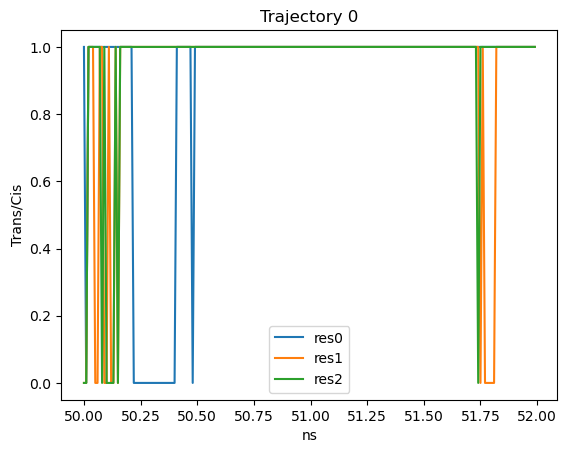

(600030, 3)


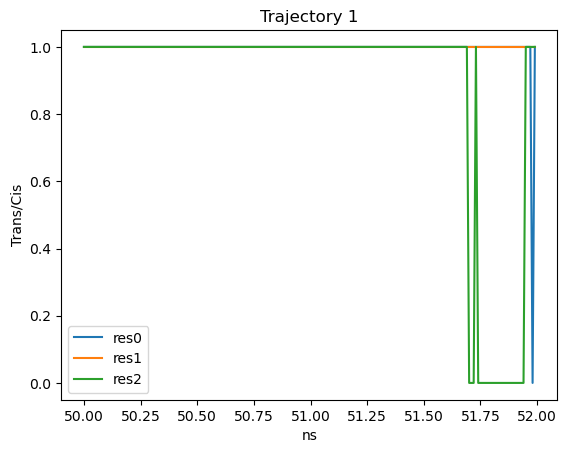

(600030, 3)


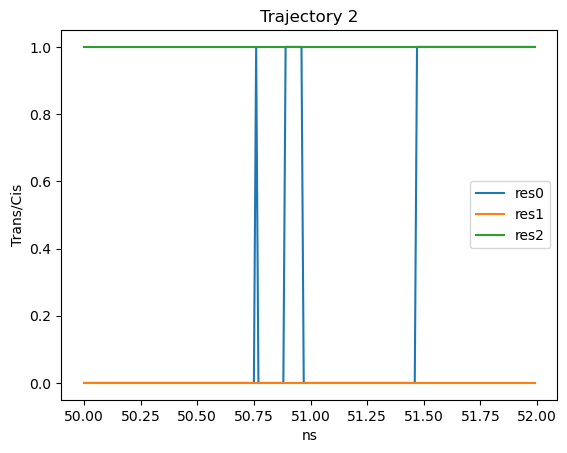

(600030, 3)


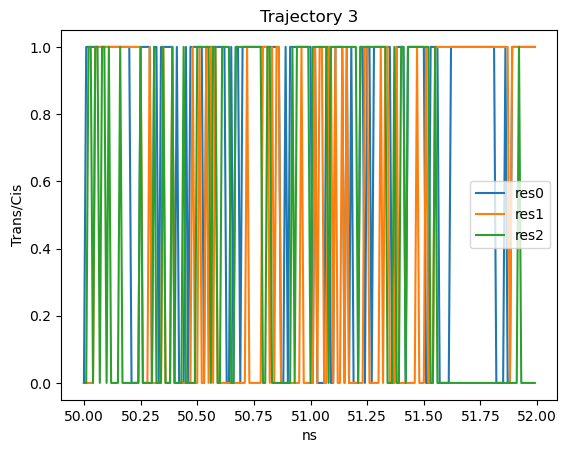

(600030, 3)


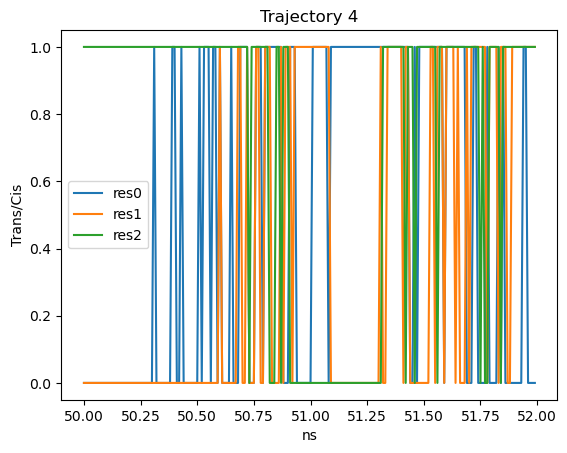

(600030, 3)


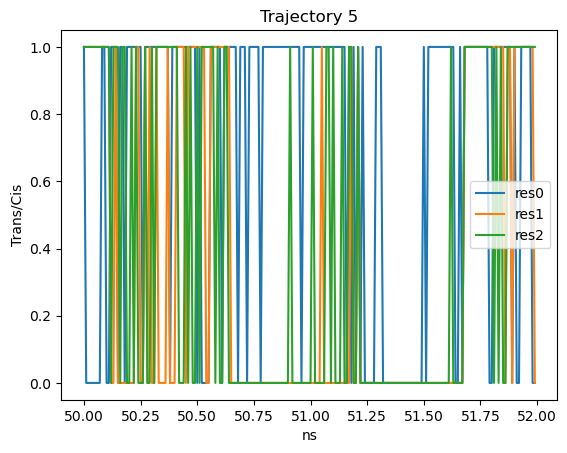

In [21]:
step_to_plot = np.arange(5000, 5200)  # Corrected step range
dt_in_ns = 0.01 # 10 ps to 1 ns

for i in range(6):
    print(traj[i].shape)
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 0], label='res0')  # X component
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 1], label='res1')  # Y component
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 2], label='res2')  # Z component
    
    plt.xlabel("ns")
    plt.ylabel("Trans/Cis")
    plt.legend(loc='best')  # Automatically places the legend in the best position
    plt.title(f"Trajectory {i}")
    plt.show()


### Calculating the implied timescale and stationary population

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

dt_in_ns = 0.01
residues = [0, 1, 2]

n_result = len(all_omega)  # Ensure all_omega is defined
n_trajs = traj  # Ensure traj is defined

num_states = 2
#lagtimes = [5, 10, 25, 50]
lagtimes = [5, 10, 25, 50] + list(range(100, 600030, 500))
cluster_size = 1

# Store results with proper shape: (n_residues, n_lagtimes)
pi_all_means = []
pi_all_stds = []
t2_all_means = []
t2_all_stds = []
transition_matrices_all_res = []

for residue in residues:
    print(f'Processing residue {residue} with lagtimes = {lagtimes}')
    
    pi_means_res = []
    pi_stds_res = []
    t2_means_res = []
    t2_stds_res = []
    transition_matrices_res = []
    
    for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):
        pi_means, pi_std, t2_mean, t2_std, transition_matrices= process_trajectory(n_trajs[:, :, residue], lagtime, num_states, cluster_size)
        
        pi_means_res.append(pi_means)
        pi_stds_res.append(pi_std)
        t2_means_res.append(t2_mean)
        t2_stds_res.append(t2_std)

    # Append per-residue results
    pi_all_means.append(pi_means_res)
    pi_all_stds.append(pi_stds_res)
    t2_all_means.append(t2_means_res)
    t2_all_stds.append(t2_stds_res)
    transition_matrices_all_res.append(transition_matrices)

# Convert to NumPy arrays for easier indexing
pi_all_means = np.array(pi_all_means)  # Shape: (n_residues, n_lagtimes)
pi_all_stds = np.array(pi_all_stds)
t2_all_means = np.array(t2_all_means)
t2_all_stds = np.array(t2_all_stds)
transition_matrices_all_res = np.array(transition_matrices_all_res)

lagtimes_ns = np.array(lagtimes) * dt_in_ns


Processing residue 0 with lagtimes = [5, 10, 25, 50, 100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600, 5100, 5600, 6100, 6600, 7100, 7600, 8100, 8600, 9100, 9600, 10100, 10600, 11100, 11600, 12100, 12600, 13100, 13600, 14100, 14600, 15100, 15600, 16100, 16600, 17100, 17600, 18100, 18600, 19100, 19600, 20100, 20600, 21100, 21600, 22100, 22600, 23100, 23600, 24100, 24600, 25100, 25600, 26100, 26600, 27100, 27600, 28100, 28600, 29100, 29600, 30100, 30600, 31100, 31600, 32100, 32600, 33100, 33600, 34100, 34600, 35100, 35600, 36100, 36600, 37100, 37600, 38100, 38600, 39100, 39600, 40100, 40600, 41100, 41600, 42100, 42600, 43100, 43600, 44100, 44600, 45100, 45600, 46100, 46600, 47100, 47600, 48100, 48600, 49100, 49600, 50100, 50600, 51100, 51600, 52100, 52600, 53100, 53600, 54100, 54600, 55100, 55600, 56100, 56600, 57100, 57600, 58100, 58600, 59100, 59600, 60100, 60600, 61100, 61600, 62100, 62600, 63100, 63600, 64100, 64600, 65100, 65600, 66100, 66600, 67100, 67600, 68100, 68600, 691

Processing Lag Times:   0%|          | 0/1204 [00:03<?, ?lag/s]


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 274, in main
    del registry[rtype][name]
KeyError: '/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/joblib_memmapping_folder_1905_7e29779873ad4e6596bfc5dca27363d9_515f6d999f474cfc982249af54334f9a/1905-140215388799664-4791369544384248b5bdddf29e1fcc4f.pkl'


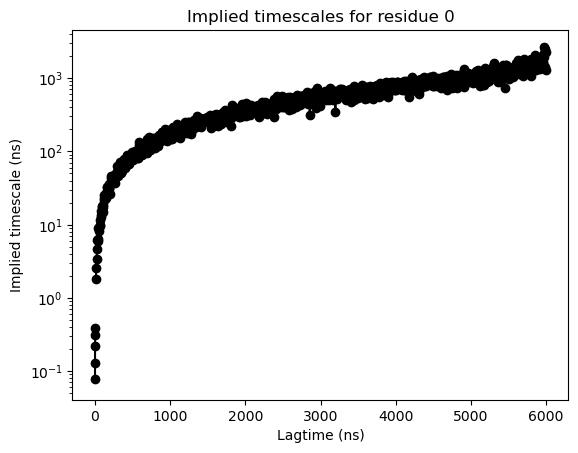

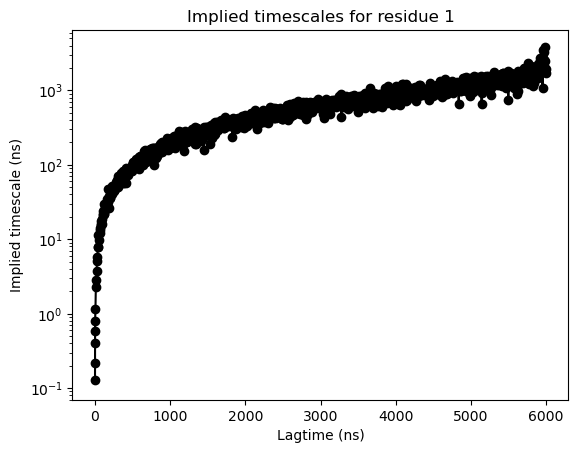

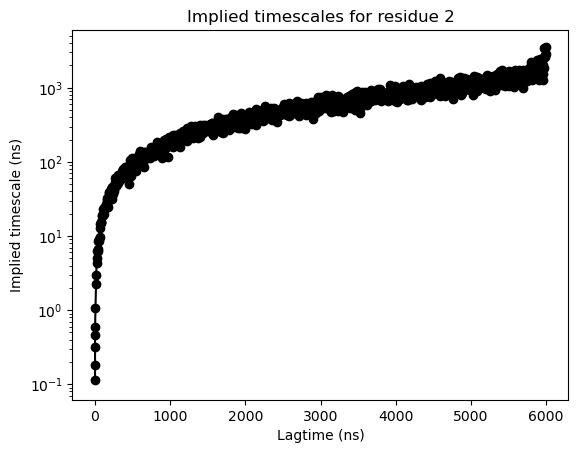

In [ ]:
# Plotting
for i, residue in enumerate(residues):
    plt.figure()
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'ko-')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=0.2)
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Implied timescale (ns)')
    #plt.ylim(5, 1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue}')
    plt.savefig(f"autocoorel_data/implied_timescale_res{residue}.png")
    plt.show()

In [ ]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_stds, 
                      t2_all_means, t2_all_stds, lagtimes_ns])

# Save to a file
data_instance.save("autocoorel_data/residue_implied_timescale.pkl")
print(f" data save at autocoorel_data/residue_implied_timescale.pkl")

 data save at autocoorel_data/residue_implied_timescale.pkl


## Load in and plot the data

In [3]:
omega_loaded = Data.load("autocoorel_data/residue_implied_timescale.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_stds = omega_loaded[1]
t2_all_means = omega_loaded[2]
t2_all_stds = omega_loaded[3]
lagtimes_ns = omega_loaded[4]

pi_all_means.shape


(3, 1204, 2)

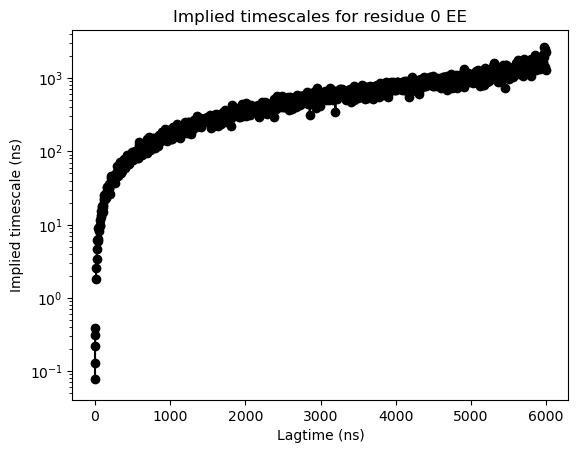

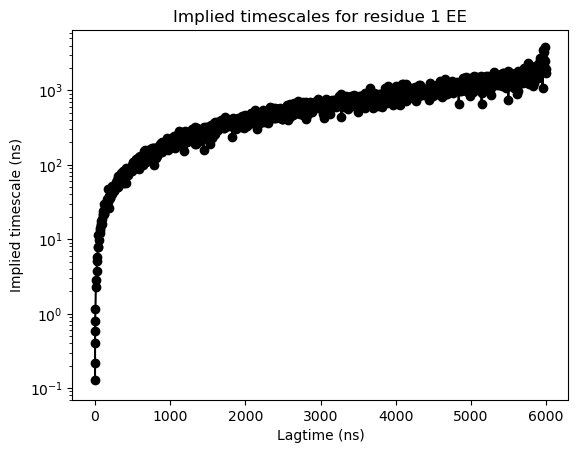

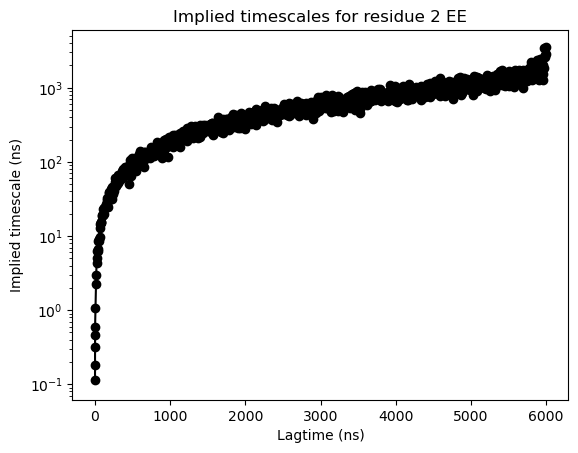

In [4]:
# Plotting
residues = [0, 1, 2]
dt_in_ns = 0.01 # 10 ps per step
for i, residue in enumerate(residues):
    plt.figure()
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'ko-')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=0.2)
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Implied timescale (ns)')
    #plt.ylim(5, 1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue} EE')
    #plt.show()
    plt.savefig(f"autocoorel_data/implied_timescale_res{residue}.png")

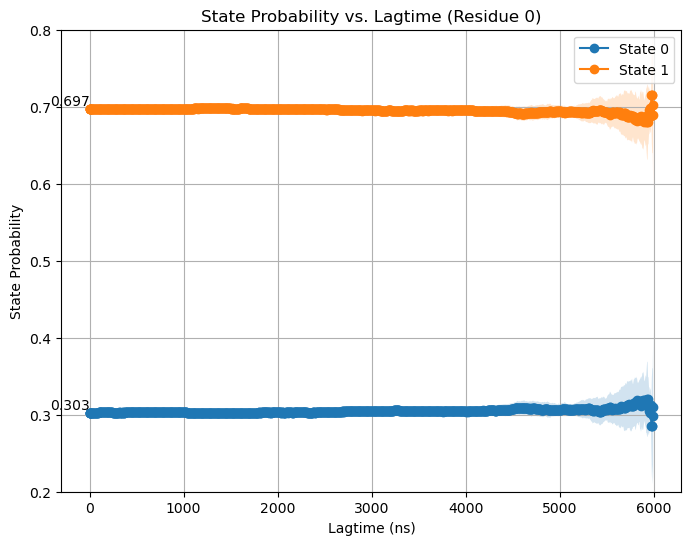

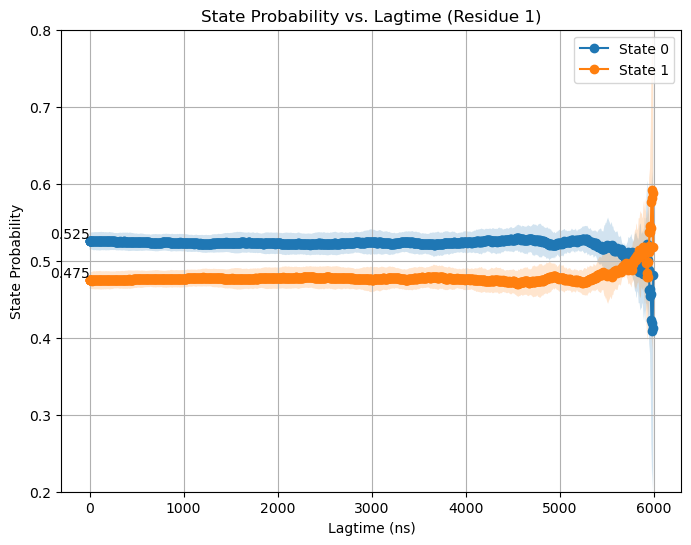

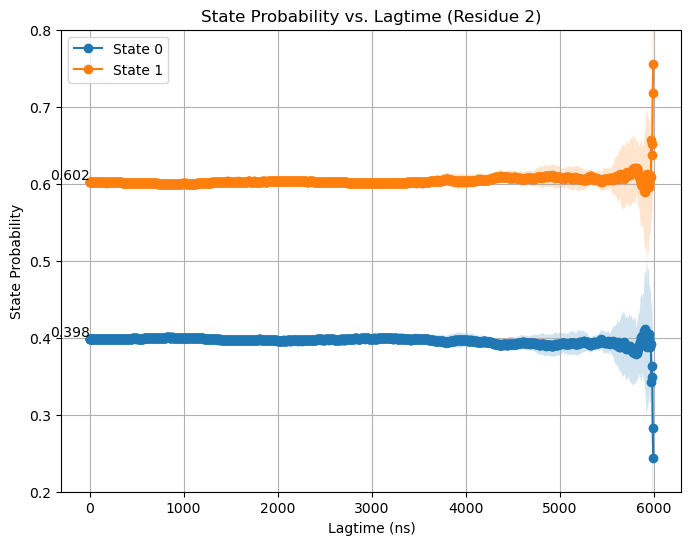

In [8]:
import matplotlib.pyplot as plt

residues = [0, 1, 2]
dt_in_ns = 0.01  # 10 ps per step
state_to_plot = [0, 1]

for res in residues:
    plt.figure(figsize=(8, 6))  # Create a new figure for each residue
    pi_means = pi_all_means[res]
    pi_stds = pi_all_stds[res] 

    for i, state in enumerate(state_to_plot):
        plt.plot(lagtimes_ns, pi_means[:, i], '-o', label=f'State {state}')
        
        # Add shaded region for standard deviation
        plt.fill_between(lagtimes_ns, 
                         pi_means[:, i] + pi_stds[:, i],  # Upper bound
                         pi_means[:, i] - pi_stds[:, i],  # Lower bound
                         alpha=0.2)
        
        # Annotate the first point with its value
        first_x = lagtimes_ns[0]
        first_y = pi_means[0, i]
        plt.text(first_x, first_y, f"{first_y:.3f}", fontsize=10, ha='right', va='bottom')
    
    plt.xlabel("Lagtime (ns)")
    plt.ylabel("State Probability")
    plt.title(f"State Probability vs. Lagtime (Residue {res})")
    plt.legend()
    plt.grid(True)
    plt.ylim(0.2, 0.8)
    
    # Fix: Use `res` instead of `residue`
    plt.savefig(f"autocoorel_data/stationary_population_res{res}.png", dpi=300)
    plt.show()
